# Sinusoidal Positional Encodin

いわゆる絶対位置でのsin,cosを使った位置埋め込み

### Reference
- https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py
    - MAEの公式実装のとこのやつ

sin関数とcos関数を使った学習不要な位置埋め込みであり
トークンの位置を$t$、トークンベクトルの各成分をsin,cosの組を交互に並べた時の組の番号を$i$、埋め込み次元数を$d_{\text{model}}$とするとその成分の値は以下のように計算できる
$$
p_{t,2i} = \sin (w_i \cdot t) = \sin ( \frac{1}{10000^{2i/d_{\text{model}}}} \cdot t) \\
p_{t,2i+1} = \cos (w_i \cdot t) = \cos ( \frac{1}{10000^{2i/d_{\text{model}}}} \cdot t)
$$
$t$個目のトークンの$m$番目の成分の値が$p_{t,m}$に対応している

In [1]:
import numpy as np
import torch

In [2]:
def get_2d_sincons_pos_embed(embed_dim,grid_size,cls_token=False):
    """
    Args:
        embed_dim (int): トークンの長さ、次元数
        grid_size (int): パッチ分割の格子の縦、横の長さ 
    Returns:
        pos_embed (ndarray): [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size,dtype=np.float32)
    grid_w = np.arange(grid_size,dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0) 
    grid = grid.reshape([2, 1, grid_size, grid_size]) # (2,grid_size,grid_size) -> (2,1,grid_size,grid_size)
    
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

In [3]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    Args:
        embed_dim (int): トークンの長さ、次元数
        pos (ndarray): 符号化する位置のリスト: shape=(M,)
    Returns:
        ndarray: 位置埋め込みベクトル: shape(M,embed_dim)
    """
    assert embed_dim%2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim /2.
    omega = 1. / 10000**omega
    
    pos = pos.reshape(-1)
    out = np.einsum("m,d->md",pos,omega) # shape=(m,embed_dim/2)

    emb_sin = np.sin(out)
    emb_cos = np.cos(out)

    #emb = np.concatenate([emb_sin,emb_cos],axis=1) # shape=(m,embed_dim)
    
    ## ちゃんと交互にsin,cosが来るようにしまーす
    m = emb_sin.shape[0]
    emb = np.empty(shape=(m,embed_dim))
    emb[:,0::2] = emb_sin
    emb[:,1::2] = emb_cos
    
    return emb

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    """
    Args:
        embed_dim (int): トークンの長さ、次元数
        grid (ndarray): 符号化する位置のリスト: shape=(H,W)
    Returns:
        ndarray: 位置埋め込みベクトル: shape(H*W,embed_dim)
    """
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

In [4]:
embed_dim = 64
grid_size = 4
cls_token = False

In [5]:
pos_emb = get_2d_sincons_pos_embed(embed_dim,grid_size,cls_token)

In [6]:
pos_emb.shape

(16, 64)

In [7]:
import matplotlib.pyplot as plt

In [8]:
# 1d
embed_dim = 64
size = 16
pos = np.array(list(range(size)))

pos_emb = get_1d_sincos_pos_embed_from_grid(embed_dim,pos)

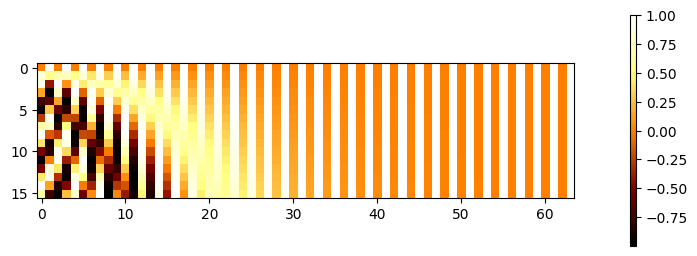

In [9]:
fig = plt.figure(figsize=(9,3))
plt.imshow(pos_emb,cmap="afmhot")
plt.colorbar(aspect=40, pad=0.08, orientation='vertical')

plt.show()

In [10]:
# 2d
embed_dim = 64
grid_size = 8
cls_token = False

pos_emb = get_2d_sincons_pos_embed(embed_dim,grid_size,cls_token)

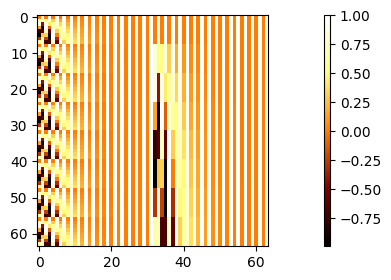

In [11]:
fig = plt.figure(figsize=(9,3))
plt.imshow(pos_emb,cmap="afmhot")
plt.colorbar(aspect=40, pad=0.08, orientation='vertical')

plt.show()

In [12]:
# similarity
import torch.nn.functional as F

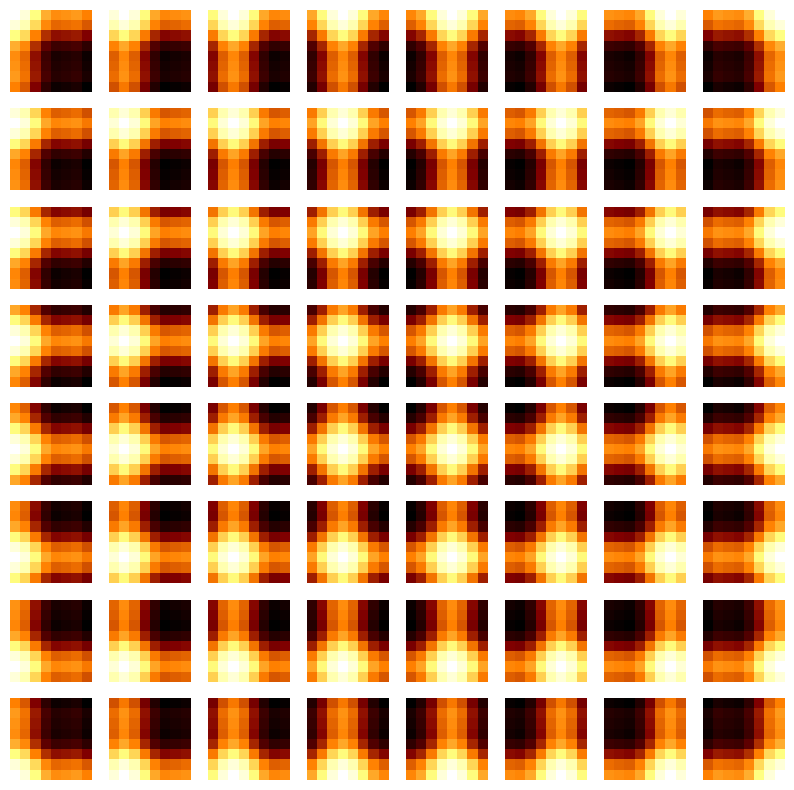

In [99]:
# 2d
fig = plt.figure(figsize=(10,10))
pos_emb = get_2d_sincons_pos_embed(embed_dim,grid_size,cls_token)
pos_emb = torch.from_numpy(pos_emb)
for i in range(0,pos_emb.shape[0]):
    sim = F.cosine_similarity(pos_emb[i:i+1], pos_emb, dim=1)
    sim = sim.reshape((grid_size,grid_size)).detach().cpu().numpy()
    ax = fig.add_subplot(grid_size,grid_size,i+1)
    plt.axis("off")
    ax.imshow(sim,cmap="afmhot")
#plt.colorbar(aspect=40, pad=0.08, orientation='vertical')
plt.show()

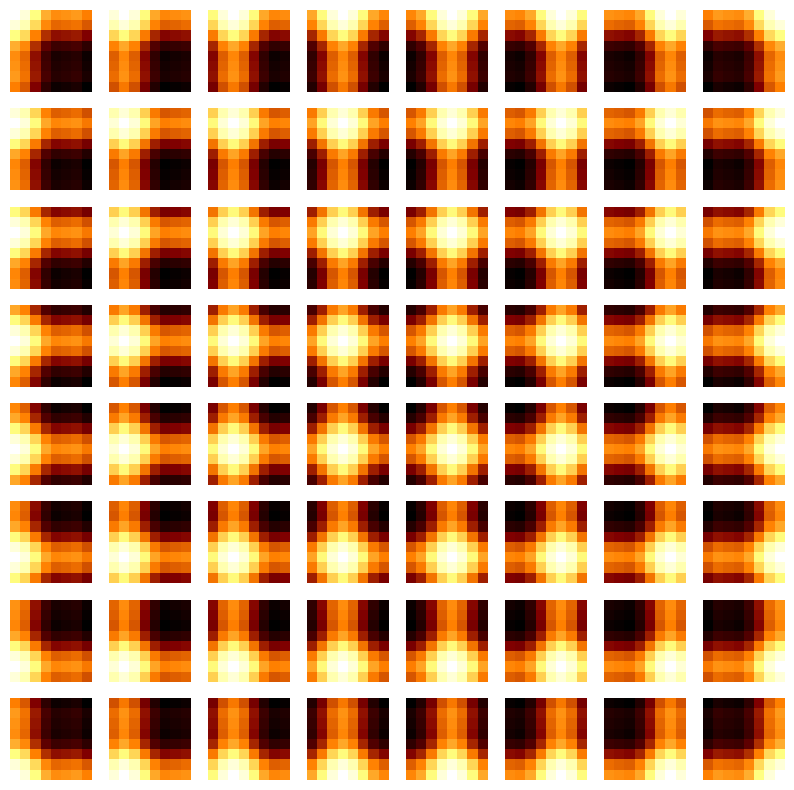

In [13]:
# 2d
fig = plt.figure(figsize=(10,10))
pos_emb = get_2d_sincons_pos_embed(embed_dim,grid_size,cls_token)
pos_emb = torch.from_numpy(pos_emb)
for i in range(0,pos_emb.shape[0]):
    sim = F.cosine_similarity(pos_emb[i:i+1], pos_emb, dim=1)
    sim = sim.reshape((grid_size,grid_size)).detach().cpu().numpy()
    ax = fig.add_subplot(grid_size,grid_size,i+1)
    plt.axis("off")
    ax.imshow(sim,cmap="afmhot")
#plt.colorbar(aspect=40, pad=0.08, orientation='vertical')
plt.show()

In [69]:
## sandbox